In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

## matplot lib settings for consistent plotting

%matplotlib inline 

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (30,10)
VERY_SMALL_SIZE = 4
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## setting up the sentiment analysis

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Setting up dataframes

We need to associate all the quotations we have with their associated polarity score. Furthermore, we add some time-related attributes to be able to plot appropriately the evolution of the polarity through time.

In [45]:
df = pd.read_pickle("pickles/sanitized_strict_df")

# extracting polarity score
df['compound'] = df.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])

# building granularity on the time to be able to extract trend

df['year'] = df.date.dt.year
df.year = df.year.astype("category")

df['month'] = df.date.dt.month
df.month = df.month.astype("category")

df['year_month'] = df.date.dt.strftime('%y-%m')
df.year_month = df.year_month.astype('category')

df['year_month_day'] = df.date.dt.strftime('%y-%m-%d')
df.year_month_day = df.year_month_day.astype('category')



# dummies is 1-hot encoding for specific climate change topics
df_dummies = pd.read_pickle("pickles/sanitized_strict_dummies")
df = df.merge(df_dummies)

#df.to_pickle("pickles/merged_sanitized_strict")

dummies_col = list(df.columns[12:])


## All topics analysis

In our dataframe, we have access to which specific climate change topic each quotation is part of. 

Nonetheless, we will first do an complete analysis disregarding topics to examine global trends.

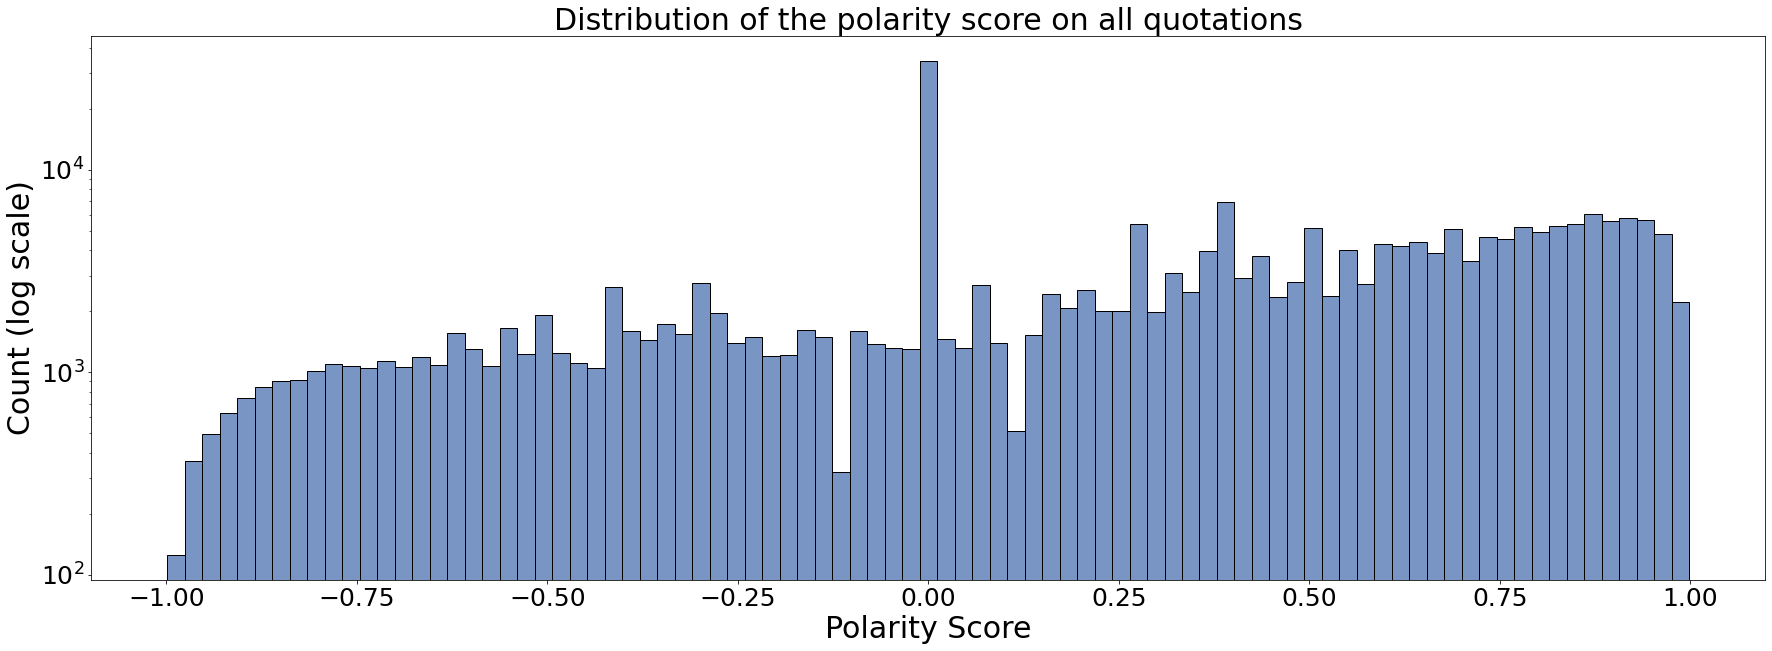

In [3]:

f,a = plt.subplots(1,1)


g= sns.histplot(data=df, x='compound')
g.set_xlabel("Polarity Score")
g.set_title("Distribution of the polarity score on all quotations")
g.set_yscale('log')
g.set_ylabel('Count (log scale)')


plt.savefig(fname="figs/total_polarity_distribution.png",dpi=300)

In [4]:
df.compound.describe()

count    243630.000000
mean          0.279800
std           0.496253
min          -0.998400
25%           0.000000
50%           0.361200
75%           0.718400
max           0.998800
Name: compound, dtype: float64

## Yearly observations

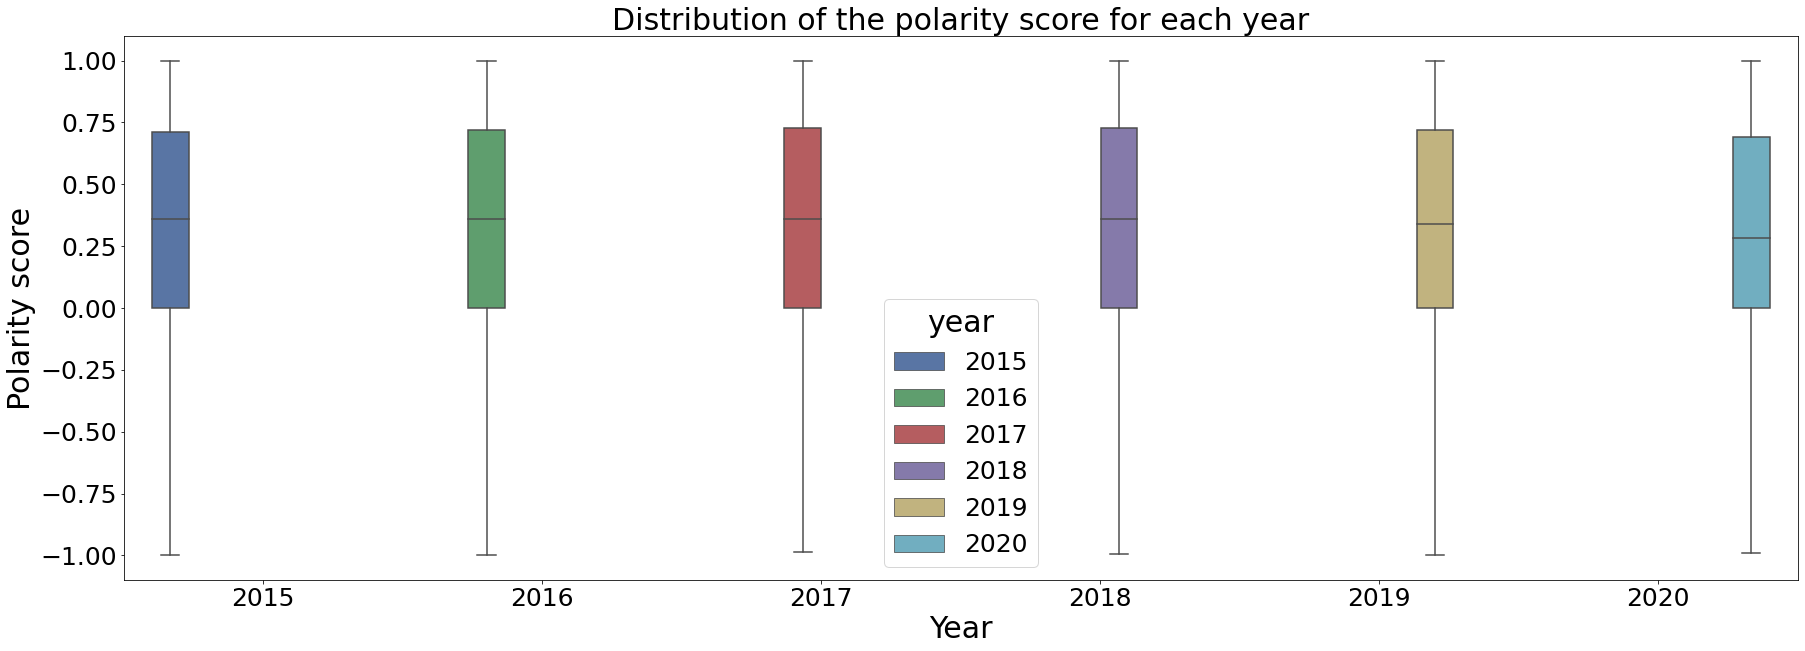

In [5]:
f,a = plt.subplots(1,1)

g= sns.boxplot(x='year', y='compound', data=df, hue ='year')

g.set_xlabel("Year")
g.set_title("Distribution of the polarity score for each year")
g.set_ylabel('Polarity score')

plt.savefig(fname="figs/boxplot_year.png",dpi=300)


We don't notice any difference between every years.

## Monthly category

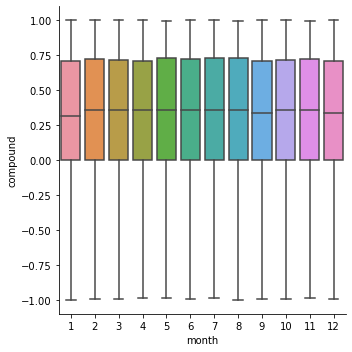

In [82]:
sns.catplot(x="month", y="compound", kind="box", data=df)

The monthly polarity scores are very stable.

## Yearly-monthly category

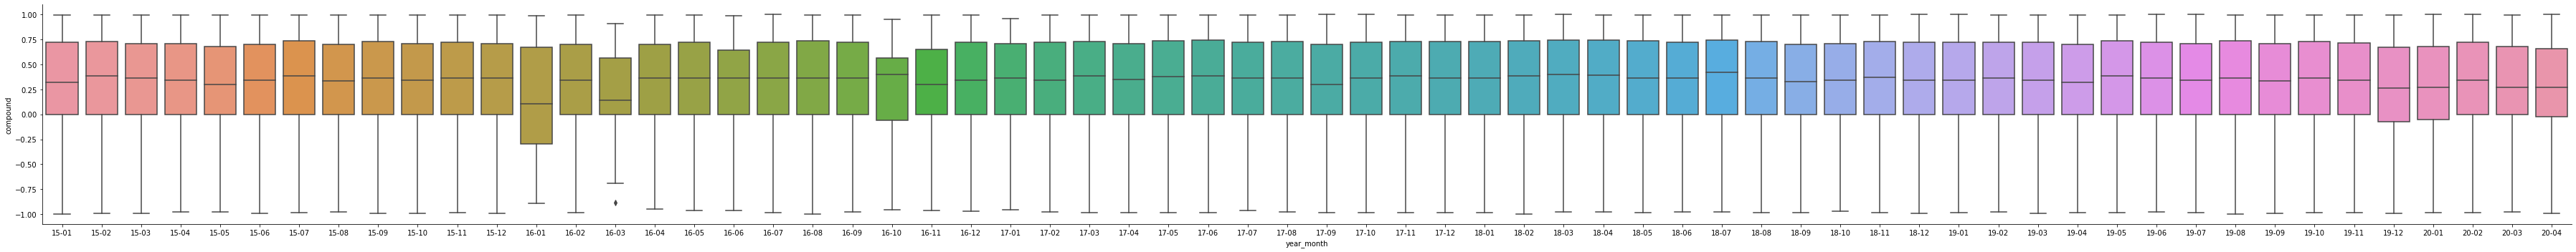

In [84]:
sns.catplot(x="year_month", y="compound", kind="box", data=df,height=5,aspect=10)

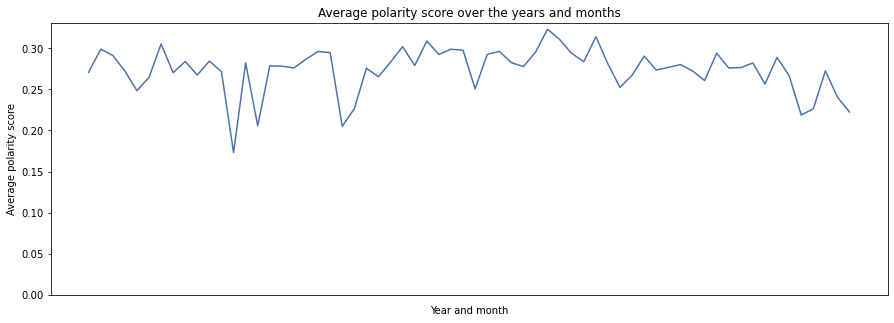

In [85]:
avg_scores = df.compound.groupby(by=df.year_month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.lineplot(x=df.year_month.cat.categories, y=avg_scores)

g.set_xlabel("Year and month")
g.set_ylabel("Average polarity score")
g.set(xticklabels=[])
g.set_title("Average polarity score over the years and months")
g.set_ylim(0)
g.tick_params(bottom=False)

Other than a small dip in November 2016, the polarity score is very stable.

## Yearly-monthly-daily category

In [47]:
def plot_compound_year_month_day_time_series(df,filter=False, granularity=True,
 savepath=None, title = None):


    ## computing the average daily polarity score
    avg_scores = df.compound.groupby(by=df.year_month_day).mean()

    f,a = plt.subplots(1,1,figsize=(20,7))

    ## setting up indices to have pretty x labels
    sel_indices = np.arange(len(avg_scores))
    avg_scores = avg_scores[sel_indices]

    # parameter to filter out small polarity scores to better see periods of high polarization
    if filter:
        avg_scores = avg_scores[:]
        avg_scores[(avg_scores < avg_scores.quantile(0.95)) & (avg_scores > avg_scores.quantile(0.05))] = 0

    # The boolean granularity defines if the x axis labels are of the format YEAR or YEAR/MONTH

    if not(granularity):
        g =sns.lineplot(x=avg_scores.index, y=avg_scores)
        length = len(avg_scores)
        years= [2015,2016,2017,2018,2019,2020]
        step = length// len(years)
        xticklabels= [years[i // step] if (i%step == 0 and i // step < 6) else "" for i in range(length)]
        a.set_xticklabels(xticklabels)
        g.set_ylim((-1,1))
        g.tick_params(bottom=False)

    else:
        plt.plot(avg_scores)
        xticklabels = np.unique(df.sort_values("date").apply(lambda e : str(e.year) + "/" + ("%02d" % e.month), axis=1).values)
        xticks = np.arange(len(avg_scores),step=len(avg_scores)//len(xticklabels))[:-1]
        a.set_xticks(xticks)
        a.set_xticklabels(xticklabels, rotation=45, fontsize=10)
   
    
    # Labelling axis
    
    a.set_xlabel("Day")
    a.set_ylabel("Average polarity score")

    plot_title = "Average daily polarity score over the years"
    if title:
        plot_title = title

    a.set_title(plot_title)


    # saving the figure

    if savepath:
        plt.savefig(savepath,dpi=300, bbox_inches='tight')


Looking at this, it seems like that the narrative hasn't been increasingly polarized but it has know periods with very high polarity, let us investiage those time periods.

C:\Users\Harold\AppData\Local\Temp/ipykernel_15568/1357242931.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(xticklabels)


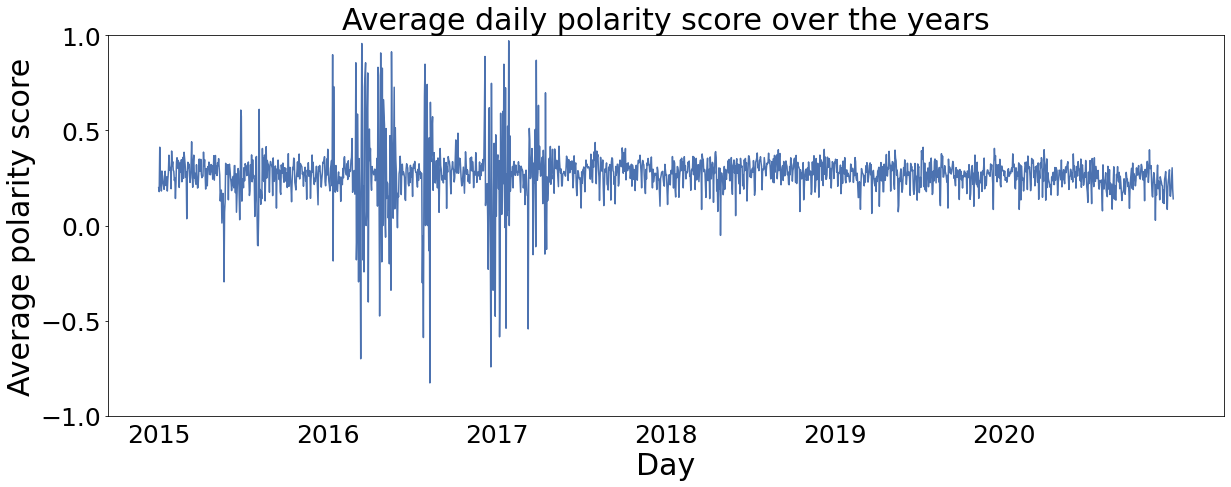

In [41]:
plot_compound_year_month_day_time_series(df,filter=False, granularity=False, savepath="figs/average_daily_polarity.png")

It looks like 2016 was highly polarized period, but looking further, it is a matter of having fewer data in 2016 which makes the daily average much more sensitive to outliers.

## Analysis on topics

Seeing that global trends aren't very insightful on understanding polarization, we decide to dig deeper in the specific topics.

#### Most negative and positive dates

Let's try to see what are the main topics during highly polarized days.

In [3]:
dummies_avg_year_month_day = df[dummies_col + ['compound']].groupby(by=df.year_month_day).mean()

In [4]:
sorted_dummies = dummies_avg_year_month_day.sort_values(by='compound')

Let's print the specific subjects that occur during highly polarized days

In [5]:
# let's find the top 5 periods of high polartiy in both directions

k = 5
offset = 0
negative_index = []
positive_index= []

print("Negative headlines\n")

for i in range(k):
    index = sorted_dummies[dummies_col].iloc[i+offset].argmax()
    subject = dummies_col[index]
    negative_index.append(sorted_dummies.index[i+offset])
    print(f"Date:{ sorted_dummies.index[i]}\tPolarity score: {sorted_dummies.iloc[i,-1]:.3f}\tSubject: {subject}\n")


print("Positive headlines\n")
for i in range(k):
    index = sorted_dummies[dummies_col].iloc[-(i+1+offset)].argmax()    
    subject = dummies_col[index]
    positive_index.append(sorted_dummies.index[-(i+1+offset)])
    print(f"Date: {sorted_dummies.index[-(i+1)]}\tPolarity score: {sorted_dummies.iloc[-(i+1),-1]:.3f}\tSubject: {subject}\n")

Negative headlines

Date:16-06-20	Polarity score: -0.827	Subject: climate

Date:16-10-16	Polarity score: -0.743	Subject: climate

Date:16-01-20	Polarity score: -0.700	Subject: fuel

Date:16-06-05	Polarity score: -0.589	Subject: climate

Date:16-11-04	Polarity score: -0.585	Subject: gas

Positive headlines

Date: 16-11-24	Polarity score: 0.971	Subject: climate

Date: 16-01-22	Polarity score: 0.957	Subject: carbon

Date: 16-04-02	Polarity score: 0.913	Subject: energy

Date: 16-03-06	Polarity score: 0.907	Subject: atmosphere

Date: 15-11-20	Polarity score: 0.898	Subject: earth



### Comparison of polemic and non-polemic topics

We need to be able to decide whether a given topic is polemic/ controversial. Looking at the definition of **controversy** from Werriam-Webster: "a discussion marked especially by the expression of opposing views".

Therefore, a topic in which the daily polarity score always hovers around the same level, i.e its mean, would be considered not controversial. Whereas a topic where the daily polarity score tends to swing between -1 and 1, can be considered as a topic where there is expression of opposing views or that a given view is expressed in a variety of way (alarmist against hopeful).

Therefore, examining the empirical variance of the daily average polarity score of a given topic seems like a reasonable heuristic.



In [9]:
topic_variances = []

# looking to classify the variance and excess kurtosis of the daily polarity scores over 5 years for each topic
# we'll filter out topics that appear too few to have an estimated variance that isn't too influenced by outliers (threshold at 100)

size_threshold = 500

# iterating over all topics
for topic in dummies_col:
    new_df = df[df[topic] == 1]
    avg_scores = new_df.compound.groupby(by=new_df.year_month_day).mean()
    if not pd.isna(avg_scores.std()) and (len(new_df) > size_threshold):
        topic_variances.append((avg_scores.std(),topic, len(new_df)))

        
# sorting in decreasing order
topic_variances.sort(reverse=True)

In [10]:
# Simple function to plot the distribution of the polarity score of a given dataframe

def plot_compound_year__month_day_distribution(df):
    avg_scores = df.compound.groupby(by=df.year_month_day).mean()
    f,x = plt.subplots(1,1,figsize=(20,7))

    g = sns.histplot(x=avg_scores,bins="auto",kde=True)
    g.set_xlabel("Average daily polarity score")
    g.set_ylabel("Count")
    g.set_title("Distribution of average daily polarity score over the years")

In [31]:
# selecting the top 4 polemic and non-polemic topics

k = 4
polemic_topics = [tup[1] for tup in topic_variances[:k]]
not_polemic_topics = [tup[1] for tup in topic_variances[-k:]]

In [32]:
polemic_topics

['wildfires', 'deforestation', 'ecosystem', 'ozone']

In [33]:
not_polemic_topics

['climate', 'gas', 'sustainable', 'energy']

In [29]:
# Reading quotes to verify if our heuristic is working and to get some examples for the data story

for topic in polemic_topics:
    new_df = df[df[topic] ==1].sort_values(by='compound', ascending = False)

    k=1
    print(new_df.quotation.head(k).to_markdown(), new_df.speaker.head(k))

|        | quotation                                                                                                                                                                                                                                                                                                                                                                                                                       |
|-------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 126579 | whether responding to storms like harvey or wildfires in west texas our state s first responders go above and beyond the call of du

In [65]:
## Function to plot multiple distributions at the same time of a given list of topics

def plot_multiple_topics(df,list_topics, polemic, savepath=None):


    # defining plotting grid
    k = len(list_topics)
    dim = [k//2 if k%2 == 0 else (k//2) + 1][0] 
    f, ax = plt.subplots(dim,2, figsize=(30,15) ,gridspec_kw={'wspace':0.2, 'hspace':1})

    # defining the title of the plot
    s = "P" if polemic else "Not p"
    plt.suptitle(f"{s}olemic topics distributions")

    # iterating over the topics and plotting
    for i in range(k):
        new_df = df[df[list_topics[i]] == 1]
        avg_scores = new_df.compound.groupby(by=new_df.year_month_day).mean()
        j,l = divmod(i,2)
        g = sns.histplot(x=avg_scores,bins="auto",kde=True, ax= ax[j][l], stat='count')
        g.set_xlabel("Average daily polarity score")
        g.set_title(f"{str.capitalize(list_topics[i])}")


    # saving the figure
    if savepath:
        plt.savefig(savepath,dpi=300, bbox_inches='tight')

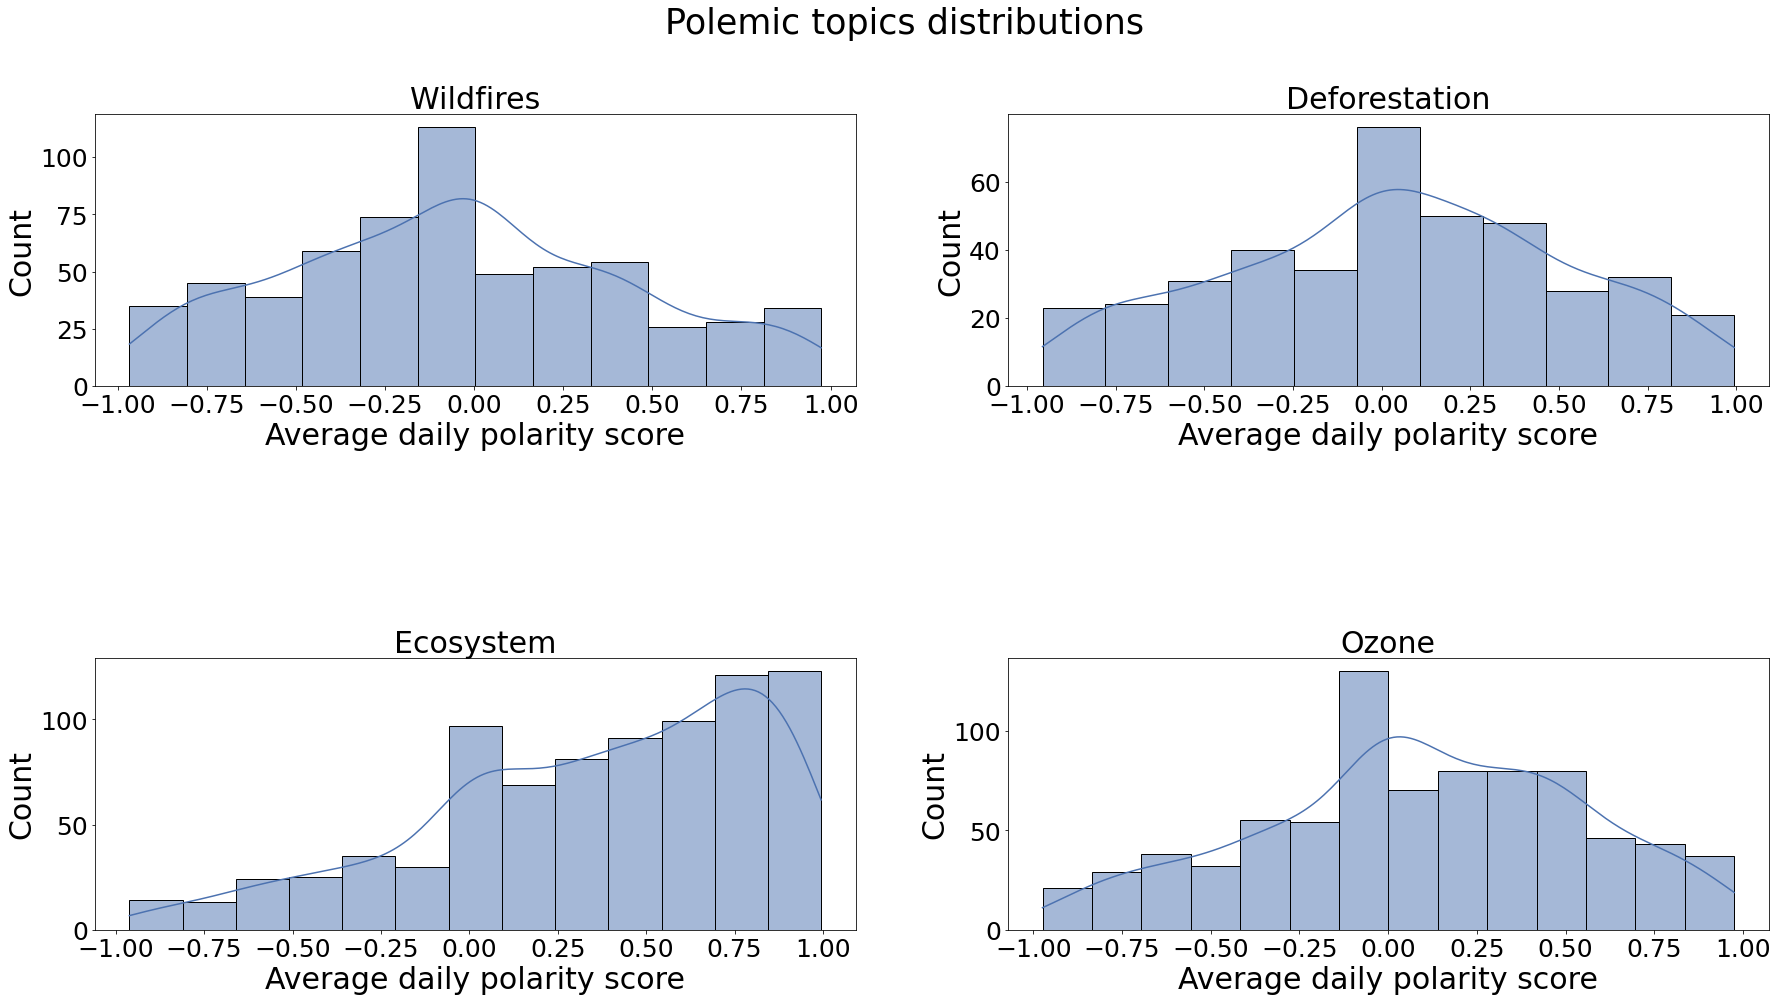

In [66]:
plot_multiple_topics(df,list_topics=polemic_topics,polemic=True, savepath="figs/polemic_distributions.png")




The distributions are spread over the entire x axis which indicates a variety of opinions and a high likelihood of polarization. It is not the typical bimodal which represents the theorical polarized distribution but it is still quite different from the non-polemic topics. 

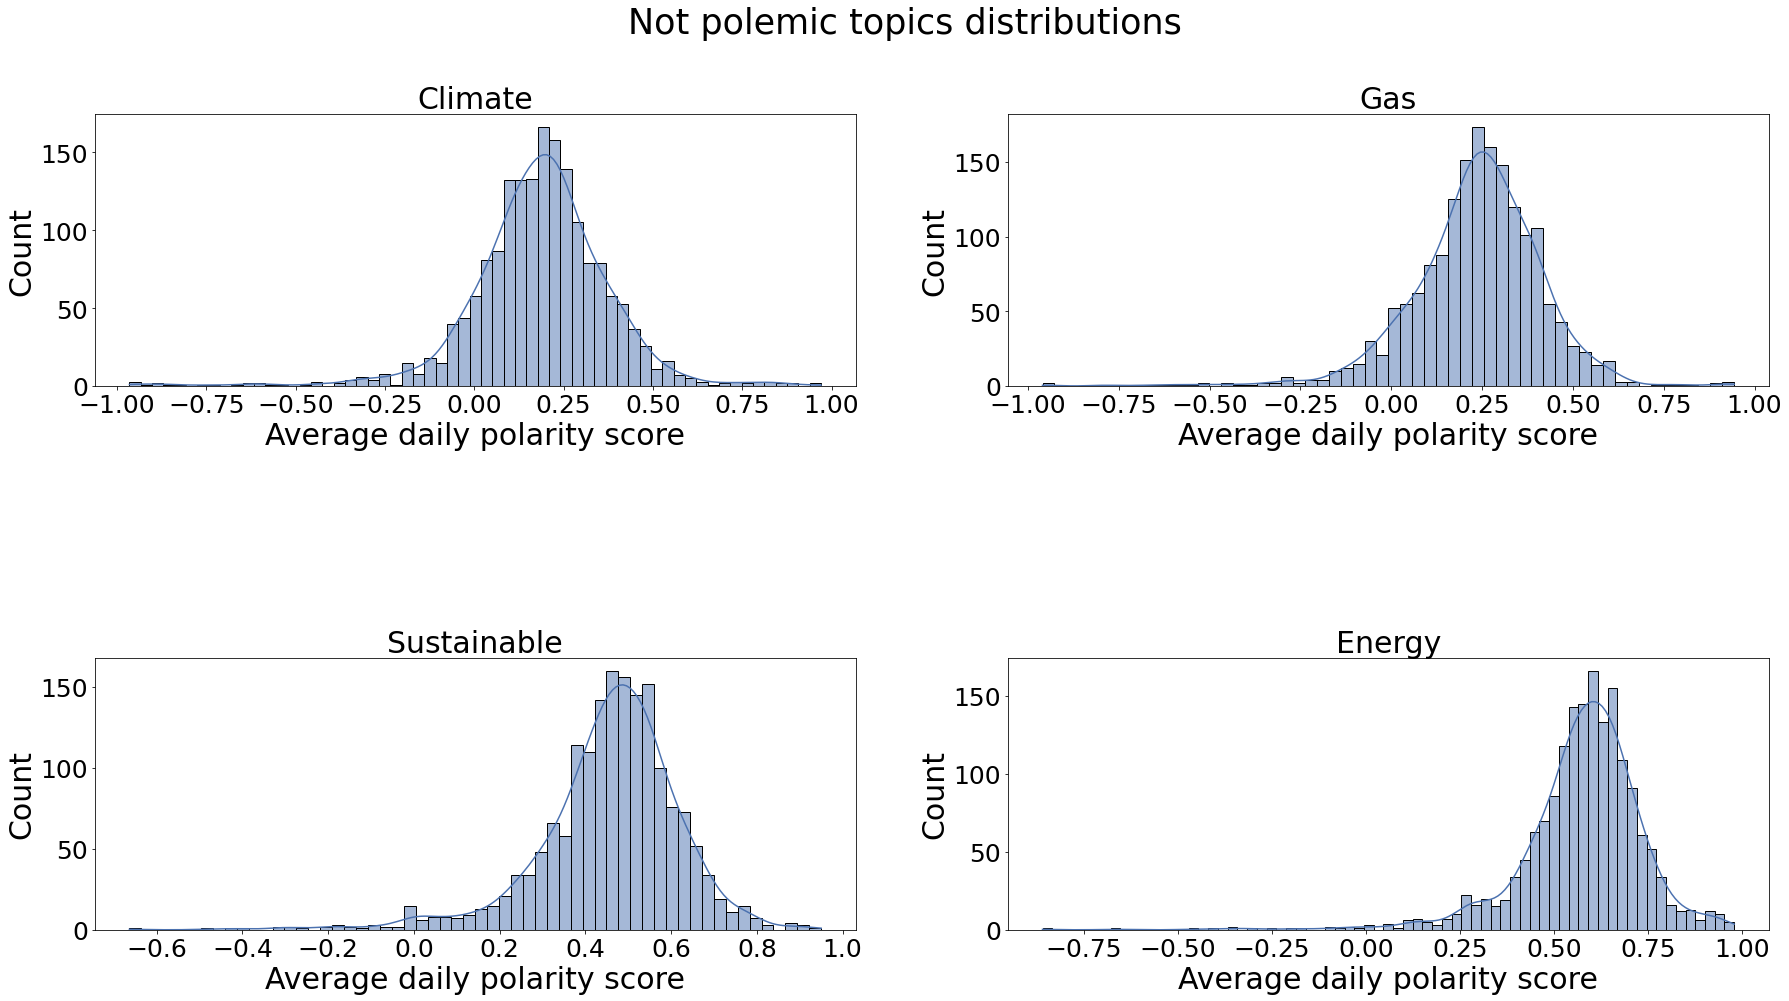

In [68]:
plot_multiple_topics(df,list_topics=not_polemic_topics,polemic=False,savepath="figs/not_polemic_distributions.png")

As we can see, non controversial topics have their distribution concentrated around a single polarity score which is positive for these 4 topics. 


Looking a little more closely at the topic of "Wildfires" and "Earth", we can see how differently the narrative evolves through time.


C:\Users\Harold\AppData\Local\Temp/ipykernel_15568/2105253879.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(xticklabels)


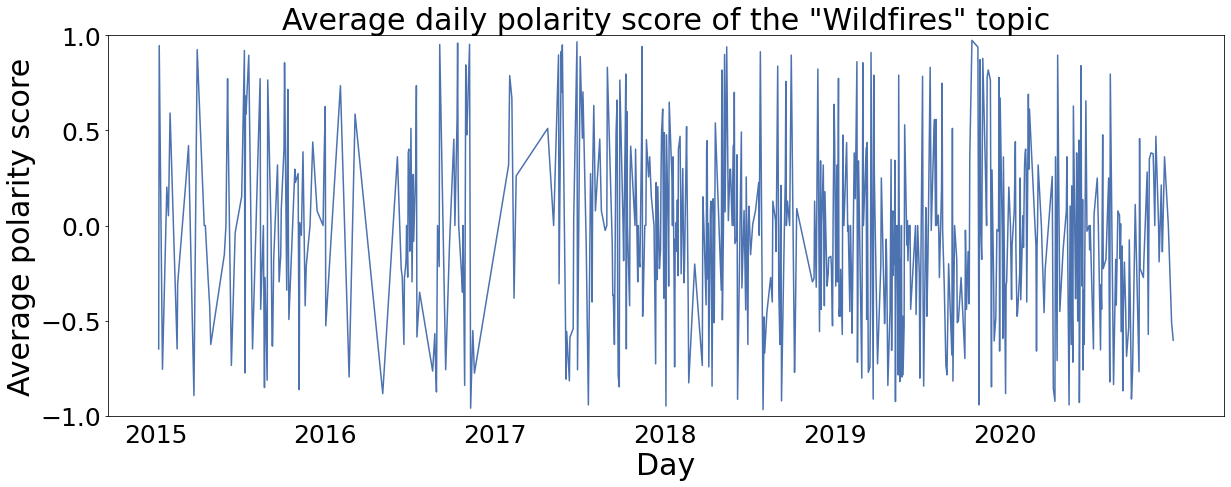

In [52]:
plot_compound_year_month_day_time_series(df[df.wildfires == 1],granularity=False,
title="Average daily polarity score of the \"Wildfires\" topic", savepath="figs/wildfires_polarity.png")

C:\Users\Harold\AppData\Local\Temp/ipykernel_15568/2105253879.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(xticklabels)


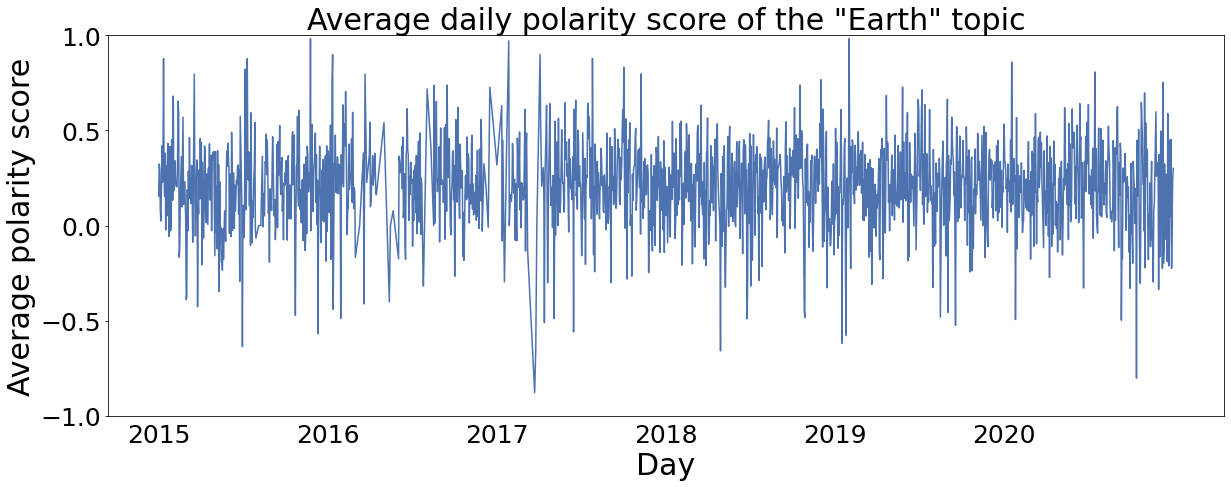

In [53]:
plot_compound_year_month_day_time_series(df[df.earth == 1],granularity=False,
title="Average daily polarity score of the \"Earth\" topic", savepath="figs/earth_polarity.png")

As we can see, the topic of wildfires tends to exert much more extreme reactions than the "earth" topic. This is somewhat expected as wildfires are natural disasters that destroy forests and homes, thus creating emotional reactions.